# 結業測驗與認證：基於 RAG 的對談系統

## 背景說明：

作為 AI 工程師職位的候選人，請建立一個基於檢索輔助生成（Retrieval-Augmented Generation，RAG）的對談系統。此系統能根據提供的文字及表格來回答問題。以下提供了一個來自城市交通分析數據集的範例表格，您的系統必須能準確地從中檢索資訊並生成回答。

## 問題：

建立一個 RAG 對話系統，能夠處理以下表格資訊，並能準確回答下列問題：
- 「請問台北市大安區與中正區的自行車占比率為多少？」

## 該系統應展示以下能力：

1. 能夠處理文件中的文字與表格內容。
2. 基於內容準確提取資訊並生成自然語言的回答。

## 交付項目：

- 一個展示您所建系統的 Jupyter Notebook。
- 一個展示設計過程與架構的簡報，包括：
  - 系統架構
  - 設計選擇
  - 您如何解決文件和圖像數據的 RAG 整合問題。

## 各運具類別市佔率

![各運具類別市佔率](test.jpg)

# 實作 - 處理文件中的文字與表格內容  
step 1 .   圖轉文 -> 文轉向量 -> 存進向量資料庫  

## jpg 轉存成 json 檔案

### 載入類別

In [ ]:
from langchain_openai import AzureChatOpenAI
from langchain_core.messages import HumanMessage
from langchain_core.output_parsers import StrOutputParser
import base64
import re
import os
from dotenv import load_dotenv, find_dotenv

### 讀取 env

In [ ]:
_ = load_dotenv(find_dotenv())

wits_gpt_endpoint = os.getenv("WITS_GPT_ENDPOINT")
wits_gpt_apikey = os.getenv("WITS_GPT_API_KEY")
wits_gpt_apiversion = os.getenv("WITS_GPT_API_VERSION")
wits_gpt_model = os.getenv("WITS_GPT_MODEL")

### 定義 Function

#### 將 image 轉成 base64

In [ ]:
def encode_image_to_base64(image_path):
    try:
        with open(image_path, "rb") as image_file:
            return base64.b64encode(image_file.read()).decode("utf-8")
    except Exception as e:
        print(f"Error encoding image: {e}")
        return None

#### 建立 image message

In [ ]:
def create_image_message(base64_image):
    return {
        "type": "image_url",
        "image_url": {
            "url": f"data:image/jpeg;base64,{base64_image}"
        }
    }

#### 從 message 抓出 json

In [ ]:
def message_to_json(json_content):
    pattern = r'```json\s*\n(.*?)\n\s*```'
    match = re.search(pattern, json_content, re.DOTALL)
    if match:
        json_content = match.group(1)
        return json_content
    else:
        print("未找到 json block")

#### 將 image 轉成 json 並存檔

In [ ]:
def image_save_to_json(image_path):
    llm = AzureChatOpenAI(
        azure_endpoint=wits_gpt_endpoint,
        openai_api_key=wits_gpt_apikey,
        deployment_name=wits_gpt_model,
        openai_api_version=wits_gpt_apiversion,
        temperature=0
    )
    if not os.path.exists(image_path):
        print(f"Error: Image file not found at {image_path}.")
        return
    base64_image = encode_image_to_base64(image_path)
    if not base64_image:
        print("Error: Failed to encode image")
        return
    image_message = create_image_message(base64_image)
    messages = [
        HumanMessage(
            content=[
                {
                    "type": "text",
                    "text": """請幫我解析這張圖片中的表格，並轉換為 json 格式。過濾掉 ```\s*?\(\d+?\)```。
                    JSON 格式參考：
                    ```
                    [
                        {
                            "District": "大安區",
                            "綠運輸": 72.9,
                            "公共運具": 51.3,
                            "非機動運具": 21.6,
                            "步行": 17.7,
                            "自行車": 3.8,
                            "私人機動運具": 27.1,
                            "最常公共運具使用率": 62.1
                        },
                        ...
                    ]
                    ```

                    輸出放到 json 區塊中：
                    ```json
                    {json_content}
                    ```
                    """
                },
                image_message
            ]
        )
    ]

    try:
        chain = llm | StrOutputParser()
        print("正在將圖片傳送至 GPT...")
        response = chain.invoke(messages)
        json_table = message_to_json(response)
        print("\n轉換結果：")
        print(json_table)
        output_file = "output_table.json"
        with open(output_file, "w", encoding="utf-8") as file:
            file.write(json_table)
        print(f"JSON 表格已保存至 {output_file}")
    except Exception as e:
        print(f"處理過程中發生錯誤: {e}")

### 執行轉換

In [ ]:
image_save_to_json("test.jpg")

## 將 json 檔案存入 VectorStore

### 讀取 json 檔案
https://python.langchain.com/docs/integrations/document_loaders/json/
https://python.langchain.com/api_reference/core/vectorstores/langchain_core.vectorstores.in_memory.InMemoryVectorStore.html#langchain_core.vectorstores.in_memory.InMemoryVectorStore

#### 安裝 Library

In [ ]:
! pip install langchain_community jq langchain-openai langchain-core

#### 載入類別

In [1]:
import os, json
from dotenv import load_dotenv, find_dotenv
from langchain_community.document_loaders import JSONLoader
from langchain_openai import AzureOpenAIEmbeddings
from langchain_core.vectorstores import InMemoryVectorStore

#### 讀取 env

In [2]:
_ = load_dotenv(find_dotenv())

wits_gpt_endpoint = os.getenv("WITS_GPT_ENDPOINT")
wits_gpt_apikey = os.getenv("WITS_GPT_API_KEY")
wits_gpt_apiversion = os.getenv("WITS_GPT_API_VERSION")
wits_gpt_model = os.getenv("WITS_GPT_MODEL")

wits_embedding_endpoint = os.getenv("WITS_EMBEDDING_ENDPOINT")
wits_embedding_apikey = os.getenv("WITS_EMBEDDING_API_KEY")
wits_embedding_apiversion = os.getenv("WITS_EMBEDDING_API_VERSION")
wits_embedding_model = os.getenv("WITS_EMBEDDING_MODEL")

#### 定義 function

##### 初始化 JSONLoader

In [3]:
def init_jsonloader(json_path):
    def metadata_func(record: dict, metadata: dict) -> dict:
        metadata = record
        return metadata
        
    return JSONLoader(
        file_path=json_path,
        jq_schema='.[]',
        content_key='.District',
        is_content_key_jq_parsable=True,
        text_content=False,
        metadata_func=metadata_func
    )

##### 初始化 Embeddings

In [4]:
def init_embeddings():
    return AzureOpenAIEmbeddings(
        azure_endpoint=wits_embedding_endpoint,
        azure_deployment=wits_embedding_model,
        openai_api_version=wits_embedding_apiversion,
        api_key=wits_embedding_apikey
    )

##### 初始化 InMemoryVectorStore

In [5]:
def init_vectorstore(embeddings):
    return InMemoryVectorStore(embeddings)

#### 執行載入 JSON 並存入 VectorStore

In [6]:
loader = init_jsonloader('output_table.json')
documents = loader.load()
embeddings = init_embeddings()
vector_store = init_vectorstore(embeddings)
vector_store.add_documents(documents)

['108a5eee-65a9-49ee-ba85-4cd792eb1d9c',
 '3959bab4-da41-4557-a130-8ae42891764b',
 '66255758-5858-4a24-97cc-0a12f9402819',
 '7a658937-275b-4952-81e5-c913b7d0ad2b',
 '426d118e-38e9-4404-89d1-85ab810c39d6',
 'ac63ea41-8e86-41d5-9bca-eb691ef774ca',
 '4be66f99-a4e8-4519-b144-5a4c64d041d8',
 '5641327b-5d83-45a6-89a4-342641d2939f',
 'e4d57bd2-f842-48fa-84c9-464eed8557da',
 '00a157fc-c833-4647-aad2-fd7c72c0640e',
 '2953bfce-9e4a-43a3-b950-e9f5d1cc1f72',
 'a52b9027-4db3-4198-81fa-f848e48664f6',
 '788544dc-145a-4ea8-a257-5cfe7a21237b']

# Chat Bot

step 2 . user 打的問題 -> 轉向量 -> 向量資料庫比對抓出最接近的資料 -> 塞prompt 給語言模型 -> 回應給user

## 安裝 Library

In [ ]:
! pip install langchain-core langgraph>0.2.27 langchain-openai

## 載入類別

In [7]:
import os
from dotenv import load_dotenv, find_dotenv
from langchain_openai import AzureChatOpenAI
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.prompts.chat import ChatPromptTemplate
from langchain_core.messages import BaseMessage, SystemMessage, HumanMessage, AIMessage, ToolMessage, trim_messages, filter_messages
from langgraph.checkpoint.memory import MemorySaver
from langchain.tools import tool
from langgraph.prebuilt import create_react_agent
from IPython.display import Image, display
from langchain_core.documents import Document
from typing_extensions import List, TypedDict, Dict
from langgraph.graph import START, END, MessagesState, StateGraph
from langgraph.prebuilt import ToolNode, tools_condition

## 讀取 env

In [8]:
_ = load_dotenv(find_dotenv())

wits_gpt_endpoint = os.getenv("WITS_GPT_ENDPOINT")
wits_gpt_apikey = os.getenv("WITS_GPT_API_KEY")
wits_gpt_apiversion = os.getenv("WITS_GPT_API_VERSION")
wits_gpt_model = os.getenv("WITS_GPT_MODEL")

wits_embedding_endpoint = os.getenv("WITS_EMBEDDING_ENDPOINT")
wits_embedding_apikey = os.getenv("WITS_EMBEDDING_API_KEY")
wits_embedding_apiversion = os.getenv("WITS_EMBEDDING_API_VERSION")
wits_embedding_model = os.getenv("WITS_EMBEDDING_MODEL")

## 定義 function

### 初始化 LLM

In [9]:
def init_llm():
    return AzureChatOpenAI(
        azure_endpoint=wits_gpt_endpoint,
        openai_api_key=wits_gpt_apikey,
        api_version=wits_gpt_apiversion,
        azure_deployment=wits_gpt_model
    )

### 資料查詢工具

In [10]:
@tool
def query_market_share(district: str):
    """
    這個工具會查詢臺北行政區的運具類別市占率。
    Args:
        district (str): 臺北行政區
    Returns:
        List[Document]: 運具類別市占率
    """
    print(f' > tool: query_or_respond_node ({district})')
    result = vector_store.similarity_search(district, k=1)
    return result

### 初始化 Graph

#### 定義節點

##### query_or_respond

In [11]:
def query_or_respond_node(state: MessagesState):
    """產生用於檢索或回應的工具呼叫。"""
    print(' > query_or_respond_node')
    trimmed_messages = trim_messages(
        state["messages"],
        strategy="last",
        token_counter=len,
        max_tokens=10,
        start_on="human",
        end_on=("human", "tool"),
        include_system=True,
    )
    prompt = ChatPromptTemplate.from_messages(
        [
            SystemMessage("你是助手。最多使用五個句子回答，以保持回答簡潔。"),
            MessagesPlaceholder(variable_name="messages")
        ]
    )
    llm = init_llm()
    llm_with_tools = llm.bind_tools([query_market_share])
    chain = prompt | llm_with_tools
    response = chain.invoke(trimmed_messages)
    return {"messages": [response]}

##### generate

In [12]:
def generate_node(state: MessagesState):
    """生成答案"""
    print(f' > generate_node')
    llm = init_llm()
    # 取得生成的 ToolMessages
    recent_tool_messages = []
    for message in reversed(state["messages"]):
        if message.type == "tool":
            recent_tool_messages.append(message)
        else:
            break
    tool_messages = recent_tool_messages[::-1]

    # 格式化為 Prompt
    docs_content = "\n\n".join(doc.content for doc in tool_messages)
    system_message_content = f'''
    你是負責問答任務的助手。使用以下檢索到的上下文來回答問題。如果你不知道答案，就說你不知道。最多使用五個句子回答，以保持回答簡潔。

    {docs_content}
    '''
    conversation_messages = [
        message
        for message in state["messages"]
        if message.type in ("human", "system")
        or (message.type == "ai" and not message.tool_calls)
    ]
    prompt = [SystemMessage(system_message_content)] + conversation_messages

    # Run
    response = llm.invoke(prompt)
    return {"messages": [response]}

#### 定義初始化

In [13]:
def init_state_graph():
    tools = ToolNode([query_market_share])
    graph = StateGraph(state_schema=MessagesState)
    graph.set_entry_point('query_or_respond')
    graph.add_conditional_edges(
        'query_or_respond',
        tools_condition,
        {END: END, 'tools': 'tools'},
    )
    graph.add_edge('tools', 'generate')
    graph.add_edge('generate', END)
    graph.add_node('query_or_respond', query_or_respond_node)
    graph.add_node('tools', tools)
    graph.add_node('generate', generate_node)
    memory = MemorySaver()
    return graph.compile(checkpointer=memory)

## 開始聊天  

### 使用 StateGraph

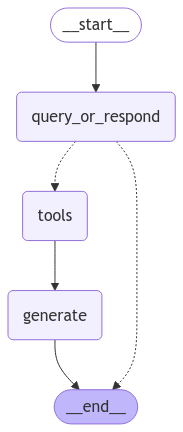

In [14]:
graph = init_state_graph()
config = {"configurable": {"thread_id": "test_thread"}}

display(Image(graph.get_graph().draw_mermaid_png()))

#### 詢問助手能做什麼

In [15]:
query = "你能做什麼呢？"
input_messages = [HumanMessage(query)]
output = graph.invoke({"messages": input_messages}, config)
output['messages'][-1].pretty_print()

 > query_or_respond_node
================================== Ai Message ==================================

我可以提供資訊、回答問題、協助解決問題，以及查詢像「臺北行政區的運具類市場占率」這類特定的資料。如果有需要幫助，請告訴我！


#### 詢問大安步行及大同自行車的市佔率

In [16]:
query = "查詢大安步行及大同自行車的市佔率。"
input_messages = [HumanMessage(query)]
output = graph.invoke({"messages": input_messages}, config)
output['messages'][-1].pretty_print()

 > query_or_respond_node
 > tool: query_or_respond_node (大安) > tool: query_or_respond_node (大同)

 > generate_node
================================== Ai Message ==================================

根據資料：

- 大安區的步行市佔率為 **17.7%**。
- 大同區的自行車市佔率為 **3.5%**。


#### 詢問松山跟信義的步行市佔率加總

In [17]:
query = "松山跟信義的步行市佔率加總是多少？"
input_messages = [HumanMessage(query)]
output = graph.invoke({"messages": input_messages}, config)
output['messages'][-1].pretty_print()

 > query_or_respond_node
 > tool: query_or_respond_node (松山)
 > tool: query_or_respond_node (信義)
 > generate_node
================================== Ai Message ==================================

松山區的步行市佔率為 **17.6%**，信義區的步行市佔率為 **17.1%**。  
加總後為 **34.7%**。


#### 詢問我說過的話

In [18]:
query = "列出我說過的話。"
input_messages = [HumanMessage(query)]
output = graph.invoke({"messages": input_messages}, config)
output['messages'][-1].pretty_print()

 > query_or_respond_node
================================== Ai Message ==================================

1. 松山跟信義的步行市佔率加總是多少？  
2. 列出我說過的話。


### 使用 create_react_agent

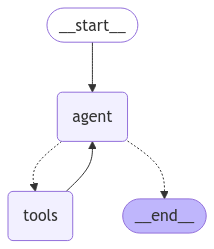

In [21]:
prompt = ChatPromptTemplate.from_messages(
    [
        SystemMessage("你是不愛說話的助手。最多使用五個句子回答，能夠只說答案就只說答案，以保持回答簡潔。"),
        MessagesPlaceholder(variable_name="messages")
    ]
)
trimmer = trim_messages(
    strategy="last",
    token_counter=len,
    max_tokens=15,
    start_on="human",
    end_on=("human", "tool"),
    include_system=True,
)
llm = init_llm()
memory = MemorySaver()
agent_executor = create_react_agent(llm, [query_market_share],
    checkpointer=memory,
    state_modifier=prompt | trimmer
)
display(Image(agent_executor.get_graph().draw_mermaid_png()))

#### 詢問助手能做什麼

In [22]:
query = "你能做什麼呢？"
input_messages = [HumanMessage(query)]
output = agent_executor.invoke({"messages": input_messages}, config)
output['messages'][-1].pretty_print()

================================== Ai Message ==================================

我能快速查詢臺北各行政區的運具類別市占率，提供簡潔答案。


#### 詢問各區的步行市佔率加總

In [23]:
for districts in [['中山區', '信義區'], ['松山區', '文山區'], ['北投區', '南港區'], ['士林區', '大同區'], ['萬華區', '內湖區']]:
    query = f'{districts[0]}跟{districts[1]}的步行市佔率加總是多少？'
    input_messages = [HumanMessage(query)]
    output = agent_executor.invoke({"messages": input_messages}, config)
    output['messages'][-1].pretty_print()

 > tool: query_or_respond_node (中山區)
 > tool: query_or_respond_node (信義區)
================================== Ai Message ==================================

中山區的步行市佔率為12.7%，信義區為17.1%，加總為29.8%。
 > tool: query_or_respond_node (松山區) > tool: query_or_respond_node (文山區)

================================== Ai Message ==================================

松山區的步行市佔率為17.6%，文山區為12.7%，加總為30.3%。
 > tool: query_or_respond_node (北投區)
 > tool: query_or_respond_node (南港區)
================================== Ai Message ==================================

北投區的步行市佔率為12.1%，南港區為11.2%，加總為23.3%。
 > tool: query_or_respond_node (士林區)
 > tool: query_or_respond_node (大同區)
================================== Ai Message ==================================

士林區的步行市佔率為16.6%，大同區為18.5%，加總為35.1%。
 > tool: query_or_respond_node (萬華區)
 > tool: query_or_respond_node (內湖區)
================================== Ai Message ==================================

萬華區的步行市佔率為10.3%，內湖區為17.9%，加總為28.2%。


#### 詢問我說過的話

In [24]:
query = "我詢問過那些行政區的資料？"
input_messages = [HumanMessage(query)]
output = agent_executor.invoke({"messages": input_messages}, config)
output['messages'][-1].pretty_print()

================================== Ai Message ==================================

士林區、大同區、萬華區、內湖區。
